# Title - Fraud Analysis Using ML Algorithms

# Problem Statement

Fraud is present across all domains and cause significant financial losses. It is needed to  analyse customer's purchase dataset and build a machine learning algorithm to detect fraud purchases.

# Objective

To detect Fraud Purchases


# Dataset Description

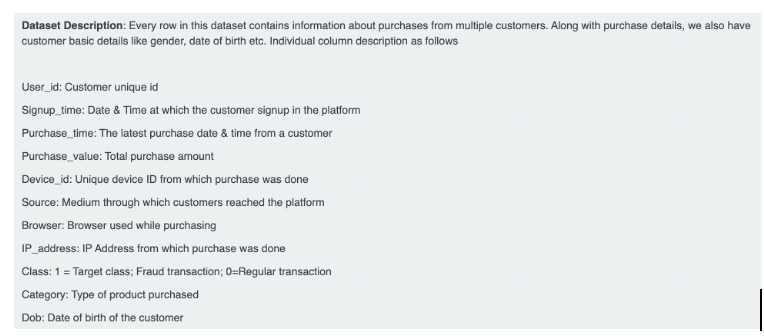

# Table of Contents

<font color=blue>
    
- Data Aquisition & Cleaning
- Exploratory Data Analysis
- Feature Engineering
- Model Training 
- Hyperparameter Tuning
- Model Evaluation 


# 1. Dataset Aquisition & Preprocessing


Loading data, exploring dataset and the necessary data cleaning.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,classification_report
from mlxtend.plotting import plot_confusion_matrix  # For plotting confusion matrix

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score, cross_validate


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [2]:
# Read data file

df = pd.read_csv('datasets/Purchase_Fraud_Data.csv')

df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962


In [3]:
df.shape

(151112, 12)

There are 151112 rows/samples and 12 columns/features.

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             146185 non-null  object 
 8   ip_address      151112 non-null  float64
 9   class           151112 non-null  int64  
 10  category        151112 non-null  object 
 11  dob             146188 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 13.8+ MB


<font color=blue>Data Types - Summarizing numerical, categorical and date columns

In [5]:
numerical_cols = df.select_dtypes(include=["int64","float64"]).columns
numerical_cols

Index(['user_id', 'purchase_value', 'ip_address', 'class'], dtype='object')

In [6]:
cat_cols = df.select_dtypes(include="object").columns
cat_cols

Index(['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex',
       'category', 'dob'],
      dtype='object')

In [7]:
df.select_dtypes("object").nunique()

signup_time      151112
purchase_time    150663
device_id        137956
source                3
browser               5
sex                   2
category              5
dob               13745
dtype: int64

In [8]:
df['user_id'].nunique()

151112

In [9]:
df['ip_address'].nunique()

143512

In [10]:
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

**Inferences**

- The `user_id` is like an identifier column as it has unique value for each record in dataset.


- `signup_time`, `purchase_time`, `dob` are identified as object data types however they need to be converted to date-time and to extract year, month,day and time features.


- `device_id` and `ip-address` have 137956 &  143512 unique values out of total 151112 records in dataset implying these are v.high cardinality features.


- Fraud transactions are very less compared to non-fraud transactions implying `imbalance in distribution` of target variable.

<font color=blue>Missing Values - Identifing and perform missing value treatment

In [11]:
missing = df.isnull().sum()
missing

user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex               4927
ip_address           0
class                0
category             0
dob               4924
dtype: int64

*Handle Missing values for `sex` and `dob`*

*We handle this missing value treatment after data split we we need to fit_transform on train data & only transform on test data to avoid data leakage*

# 2. Exploratory Data Analysis


To understand the distribution of the data, identify patterns and trends, and uncover any relationships or correlations between variables. This helps in gaining insights.

### 2a. Univariate analysis: Distribution analysis for numerical columns and frequency analysis for categorical columns)

*<font color=blue>Target Variable*

In [12]:
fraud = df['class'].value_counts()
fraud

0    136961
1     14151
Name: class, dtype: int64

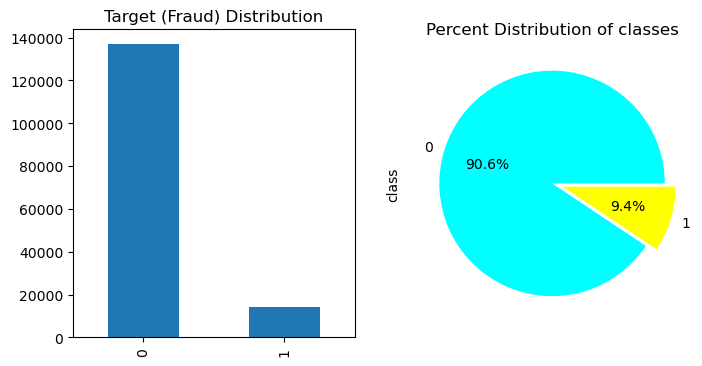

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2)

explode=(0,0.1)
fraud.plot(kind='bar',title=('Target (Fraud) Distribution'),figsize=(5,3), ax=ax[0])
fraud.plot(kind='pie', title='Percent Distribution of classes',explode=explode,autopct='%1.1f%%', colors=['cyan','yellow'],
              figsize=(8,4), ax=ax[1]);


We see that the number of Fraud cases are just 9.4% of the total available data.

*<font color=blue>Numerical Features*

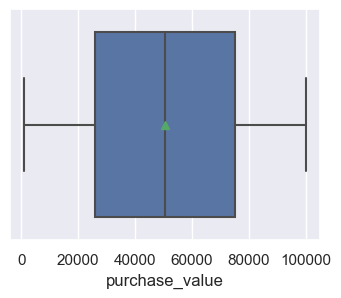

In [14]:
sns.set(rc={"figure.figsize":(4, 3)}) #width=4, #height=3
sns.boxplot(x = df['purchase_value'], showmeans = True)  
plt.show()

In [15]:
print('Mean & Median for Purchase value', round(df['purchase_value'].mean(),1), 
                                          df['purchase_value'].median())


Mean & Median for Purchase value 50521.5 50484.0


In [16]:
q1 = np.percentile(df['purchase_value'], 25)
q3 = np.percentile(df['purchase_value'], 75)
q1,q3

(25919.0, 75296.25)

- We see that the `mean as well as median` value for the purchase_value is about 50K.
- 50% of transactions are in `range` of about about 25K to 75K.

*<font color=blue>Categorical Features*

In [17]:
# Unique Values in each categorical column-
cat_cols = ['source','browser','sex','category','user_id', 'device_id','ip_address']

for i in df[cat_cols]:
    print("\033[1m" + i + "\033[0m")
    print('Unique values:',df[i].unique())
    print('Total unique values:',df[i].nunique(),'\n')

source
Unique values: ['SEO' 'Ads' 'Direct']
Total unique values: 3 

browser
Unique values: ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
Total unique values: 5 

sex
Unique values: ['M' 'F' nan]
Total unique values: 2 

category
Unique values: ['home_essentials' 'apparels' 'electronics' 'health_care' 'cosmetics']
Total unique values: 5 

user_id
Unique values: [ 22058 333320   1359 ... 368416 207709 138208]
Total unique values: 151112 

device_id
Unique values: ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ' ... 'LYSFABUCPCGBA'
 'MEQHCSJUBRBFE' 'ZINIADFCLHYPG']
Total unique values: 137956 

ip_address
Unique values: [7.32758369e+08 3.50311388e+08 2.62147382e+09 ... 2.74847052e+09
 3.60117471e+09 4.10382451e+09]
Total unique values: 143512 



**Inferences**

- For columns `'source','browser','sex','category'` have 3,5,2,5 unique values.


- For columns `user_id,device_id,ip_address` have 151112, 137956, 143512 unique values, v.high cardinality features which might not be useful w.r.t predictive analysis  as all specific to individual users,devices & hence might not be useful for pattern learning/generalizations.

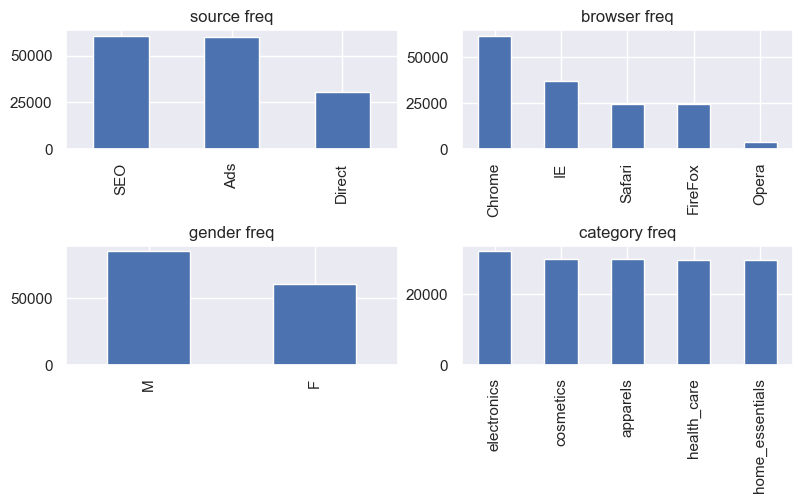

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,5))

df['source'].value_counts().plot(kind='bar',title=('source freq'),ax=ax[0,0])
df['browser'].value_counts().plot(kind='bar',title=('browser freq'), ax=ax[0,1])
df['sex'].value_counts().plot(kind='bar',title=('gender freq'), ax=ax[1,0])
df['category'].value_counts().plot(kind='bar',title=('category freq'), ax=ax[1,1])

fig.tight_layout(pad=0.5)
plt.show()

**Inferences**

- Most users using `Chrome browser` for e-commerce.
- Male users are greater in number than Female users.
- All Purchase categories are common, `electronics` category comparatively more.
- Most customers reached e-commerce platform via `Ads, SEO` rather than direct.

### 2b. Multivariate analysis to identify relationships

Exploring relationships w.r.t features and target variable.


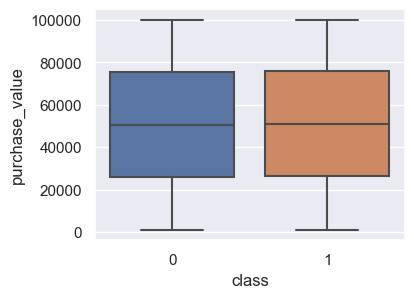

In [19]:
sns.boxplot(x='class', y='purchase_value', data=df);


*There is no significant difference b/w fraud and non-fraud transactions purchase values.*

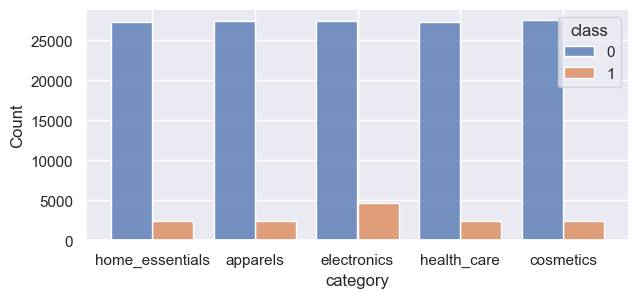

In [20]:
fig, ax1 = plt.subplots(figsize=(7, 3))

sns.histplot(data=df, x="category", hue="class", multiple="dodge", shrink=.8,ax=ax1);


*<font color=blue>Distribution of Item Categories w.r.t Fraud & Non-Fraud classes.Purchase in Electronics category more w.r.t Fraud Class.*

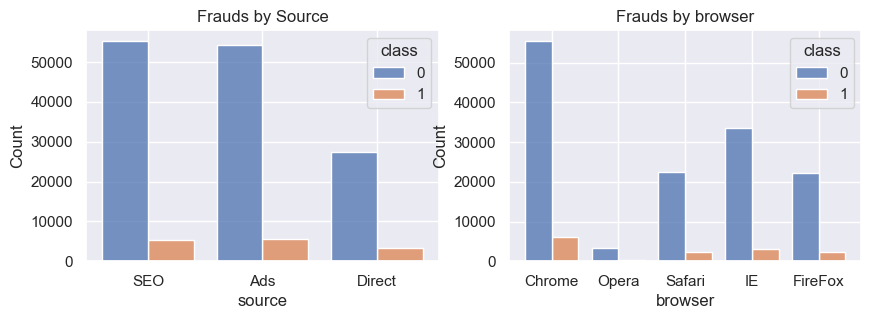

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

sns.histplot(data=df, x="source", hue="class", multiple="dodge", shrink=.8,ax=ax1)
ax1.set_title('Frauds by Source')

sns.histplot(data=df, x="browser", hue="class", multiple="dodge", shrink=.8,ax=ax2)
ax2.set_title('Frauds by browser');



*There is no noticable difference b/w fraud and non-fraud transactions w.r.t source & browser.*

Exploring correlations among features to check for multicollinearity


In [22]:
corr_matrix = df.corr()

/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_84873/3147368345.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


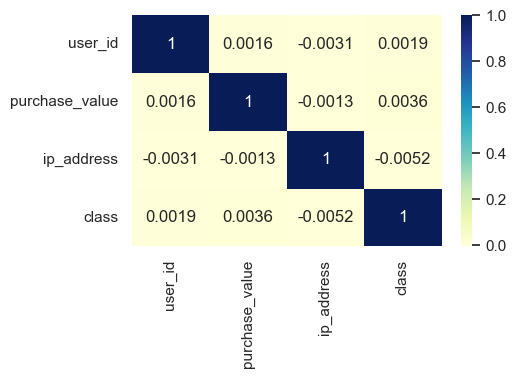

In [23]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(corr_matrix, cmap="YlGnBu",annot=True);

*There are no noticable correlations from above correlation matrix.* 

# 3. Feature Engineering

### Transforming raw data into features that are suitable for analysis.

<font color=blue> *We mainly take 3 features for engineering which are `signup_time`, `purchase_time` and `dob` from which we extract transaction information related to date, time and users information related to age.*

- signup_time, purchase_time features need to be converted to datetime and then `month, day, hour` is extracted from these columns.
- Also we make a new feature `signup_to_purchase_time` to	compute **difference between purchase time and signup time**
- Also we make a new feature `age` to get the **users age from date of birth column.**

In [24]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962


In [25]:
# Convert to datetime
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [26]:
print(df['signup_time'].min(), df['signup_time'].max())
print(df['purchase_time'].min(),df['purchase_time'].max())


2015-01-01 00:00:42 2015-08-18 04:40:29
2015-01-01 00:00:44 2015-12-16 02:56:05


The data is only for one year which is year 2015. Since year is same for all transactions we only extract the month, date and hour of transaction.

In [27]:
# Date Information
df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour


df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour


We create new feature to calculate the time difference in days between signup time and purchase time.

In [28]:
# Time information
from datetime import date, timedelta, datetime
df['signup_date'] = df['signup_time'].dt.date
df['purchase_date'] = df['purchase_time'].dt.date

df['signup_to_purchase_time'] = df['purchase_date']-df['signup_date']
df['signup_to_purchase_time'] = df['signup_to_purchase_time'].dt.days


In [29]:
# Age Information
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')
df['age_years'] = ((df['purchase_date'] - df['dob']).dt.days / 365.25).round()

# Create age buckets using binning
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
df['age_bucket'] = pd.cut(df['age_years'], bins=bins, labels=labels)


### Visualizing age_years and age_bucket columns

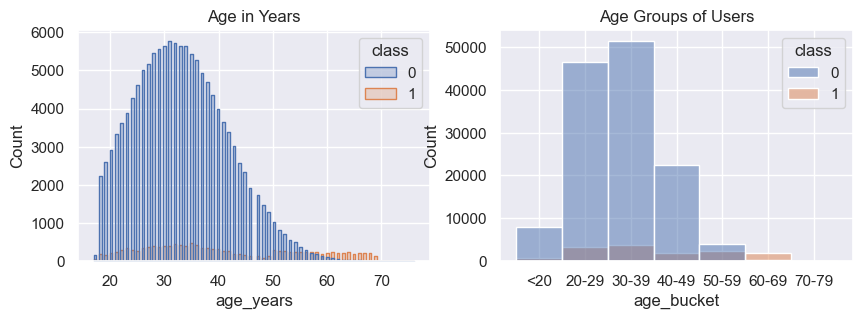

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))


sns.histplot(data=df, x="age_years", hue="class", element="step", ax=ax1);
ax1.set_title('Age in Years')

sns.histplot(data=df, x="age_bucket", hue="class", ax=ax2)
ax2.set_title('Age Groups of Users');



*<font color=blue>`Age group 60-69` is clearly distinguisable w.r.t Fraud detection as most transaction for this age group only belong to Fraud Class.*

### Visualizing purchase_value and age_bucket columns w.r.t Fraud Transcations

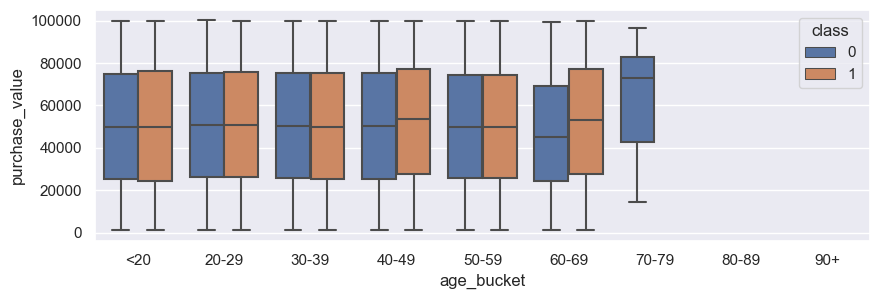

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 3))

sns.boxplot(x='age_bucket', y='purchase_value', hue='class', data=df);


*<font color=blue>For Age groups `'40-49'` and `'60-69'` the median purchase value is higher w.r.t Fraud Class.*

- We do not consider high cardinality columns i.e. user_id, ip_address, device_id as they are like identifier columns & do not help in learning patterns/generalizations w.r.t modelling.
- Columns like 'signup_time', 'purchase_time', 'dob' are feature engineered so we drop these columns.

In [32]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'ip_address', 'class',
       'category', 'dob', 'signup_month', 'signup_day', 'signup_hour',
       'purchase_month', 'purchase_day', 'purchase_hour', 'signup_date',
       'purchase_date', 'signup_to_purchase_time', 'age_years', 'age_bucket'],
      dtype='object')

In [33]:
df = df.drop(['user_id','signup_time','purchase_time','device_id','ip_address',
             'dob','signup_date','purchase_date','age_bucket'], axis=1)

In [34]:
df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'class', 'category',
       'signup_month', 'signup_day', 'signup_hour', 'purchase_month',
       'purchase_day', 'purchase_hour', 'signup_to_purchase_time',
       'age_years'],
      dtype='object')

**Split data into Train and Test**

In [35]:
# Create dependent and independent feature sets
X = df.drop(columns='class')
y = df['class']


# Spilt the data set in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 33)

print(X_train.shape)
print(X_test.shape)

(120889, 13)
(30223, 13)


In [36]:
X_train.head(3)

,purchase_value,source,browser,sex,category,signup_month,signup_day,signup_hour,purchase_month,purchase_day,purchase_hour,signup_to_purchase_time,age_years
142653,66434,Ads,Chrome,M,cosmetics,7,24,21,8,30,6,37,38.0
29572,92750,Ads,Chrome,M,home_essentials,5,26,8,6,11,18,16,37.0
87134,43704,Ads,FireFox,F,apparels,4,7,16,8,2,11,117,47.0


In [37]:
# Imputer for Age

imputer = SimpleImputer(strategy='most_frequent')
X_train['sex'] = imputer.fit_transform(X_train[['sex']])
X_test['sex'] = imputer.transform(X_test[['sex']])

In [38]:
# Imputer for Median age 

imputer = SimpleImputer(strategy='median')  # mean & median age almost same in this data
X_train['age_years'] = imputer.fit_transform(X_train[['age_years']])
X_test['age_years'] = imputer.transform(X_test[['age_years']])

**One Hot encoding for Categorical Variables**

The four categorical features `'source','browser','sex','category'` need to be one hot encoded before can be fed to ML algorithm.

In [39]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Fit on train data
ohe.fit(X_train[['source','browser','sex','category']])

OneHotEncoder()

In [40]:
# Transform on Test Data
X_train_ohe = ohe.transform(X_train[['source','browser','sex','category']])
X_test_ohe = ohe.transform(X_test[['source','browser','sex','category']])

In [41]:
X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), 
              columns=ohe.get_feature_names_out(['source','browser','sex','category']),index=X_train.index)
                             
X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), 
              columns=ohe.get_feature_names_out(['source','browser','sex','category']),index=X_test.index)


In [42]:
X_train_ohe_df.head(3)

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [43]:
X_train.head(3)

,purchase_value,source,browser,sex,category,signup_month,signup_day,signup_hour,purchase_month,purchase_day,purchase_hour,signup_to_purchase_time,age_years
142653,66434,Ads,Chrome,M,cosmetics,7,24,21,8,30,6,37,38.0
29572,92750,Ads,Chrome,M,home_essentials,5,26,8,6,11,18,16,37.0
87134,43704,Ads,FireFox,F,apparels,4,7,16,8,2,11,117,47.0


In [44]:
X_train_df = pd.concat([X_train, X_train_ohe_df], axis=1)
X_test_df = pd.concat([X_test, X_test_ohe_df], axis=1)


X_train_df.drop(['source','browser','sex','category'],axis=1, inplace=True) 
X_test_df.drop(['source','browser','sex','category'],axis=1, inplace=True) 
# drop the original categorical columns

print(X_train_df.shape)
print(X_test_df.shape)

X_train_df.head(3)

(120889, 24)
(30223, 24)


,purchase_value,signup_month,signup_day,signup_hour,purchase_month,purchase_day,purchase_hour,signup_to_purchase_time,age_years,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,66434,7,24,21,8,30,6,37,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,92750,5,26,8,6,11,18,16,37.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87134,43704,4,7,16,8,2,11,117,47.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### Correlation Matrix after Feature Engineering

In [45]:
df.head(2)

,purchase_value,source,browser,sex,class,category,signup_month,signup_day,signup_hour,purchase_month,purchase_day,purchase_hour,signup_to_purchase_time,age_years
0,65278,SEO,Chrome,M,0,home_essentials,2,24,22,4,18,2,53,39.0
1,96399,Ads,Chrome,F,0,apparels,6,7,20,6,8,1,1,53.0


/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_84873/2932638051.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


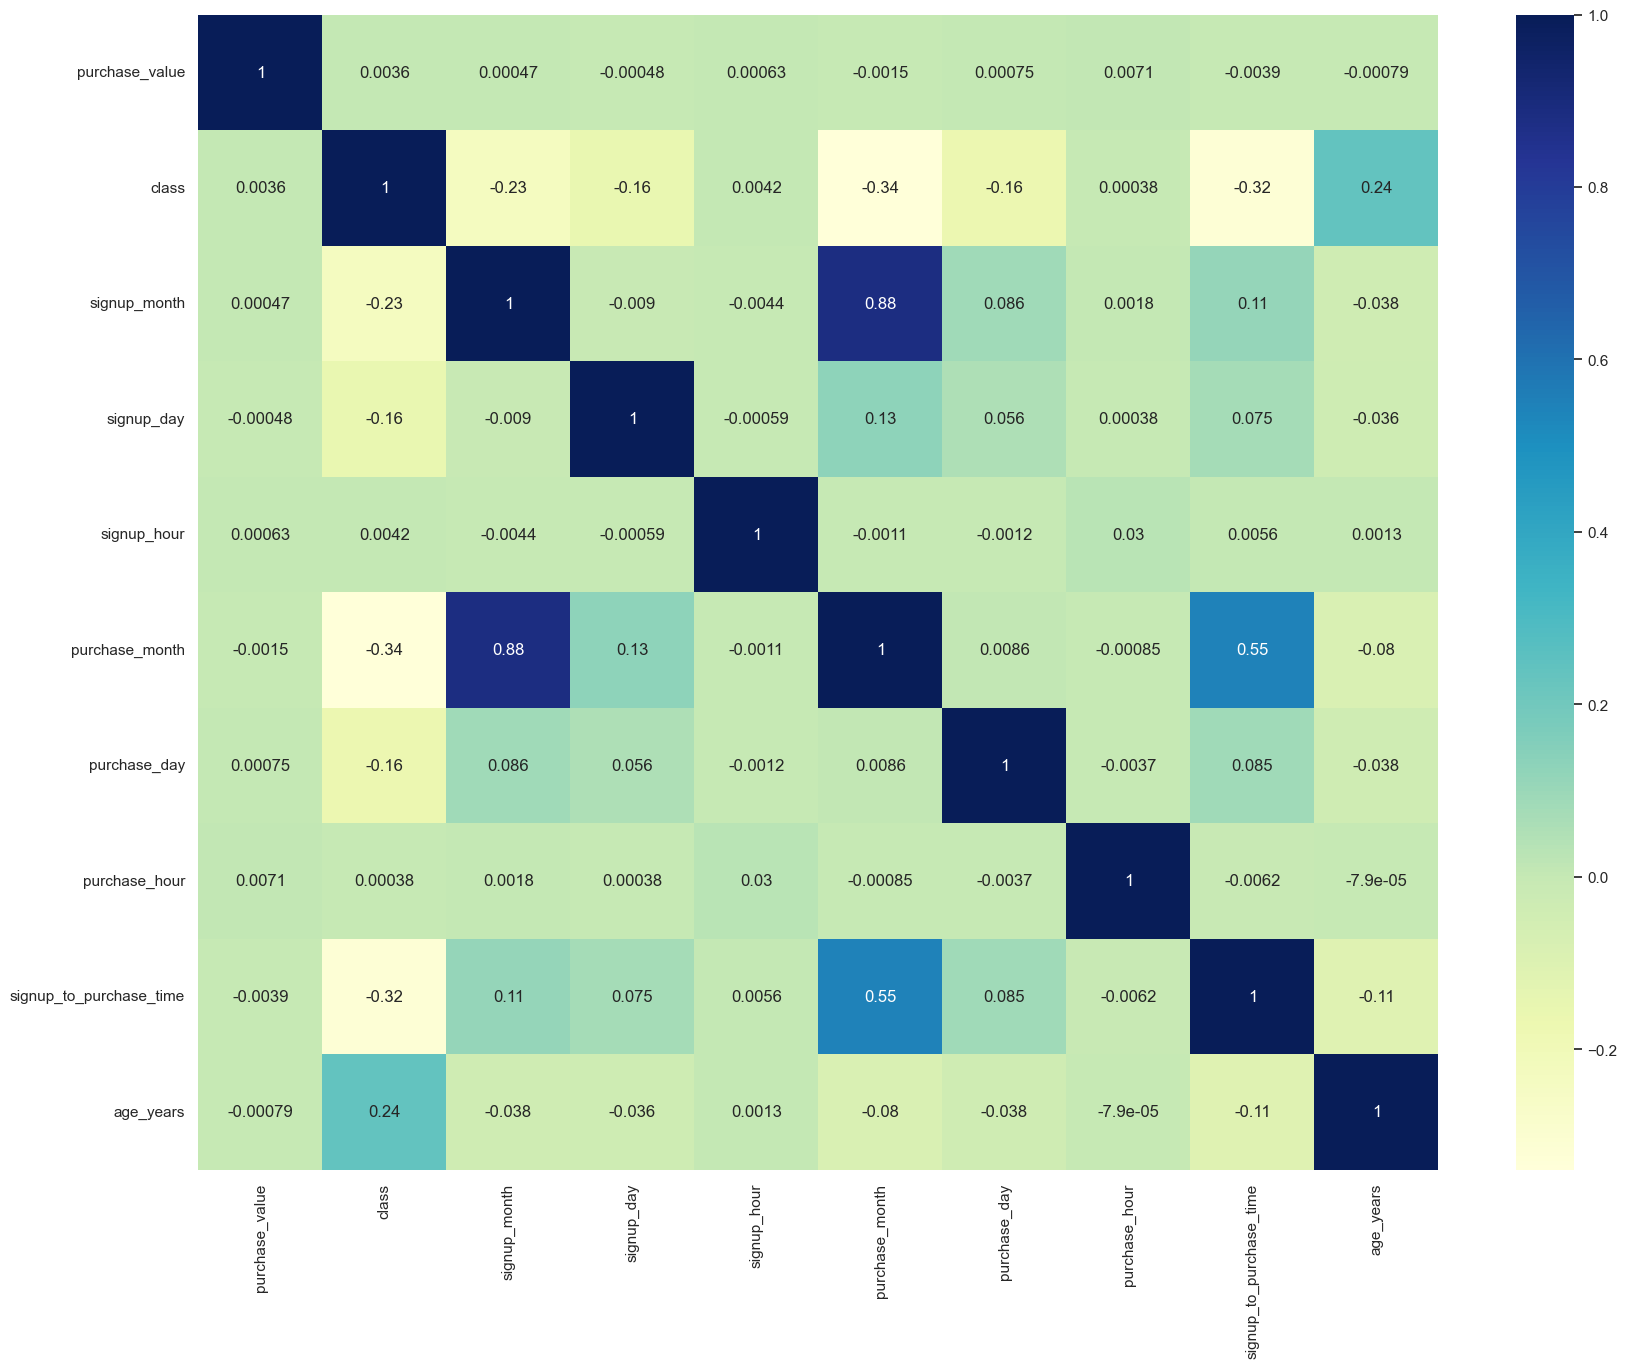

In [46]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix, cmap="YlGnBu",annot=True);

`purchase_month` is highly correlated with signup_month as well as signup_to_purchase_time feature so we drop this feature.

In [47]:
X_train_df.drop('purchase_month', axis=1,inplace=True) 
X_test_df.drop('purchase_month', axis=1,inplace=True) 

print(X_train_df.shape, X_test_df.shape)

(120889, 23) (30223, 23)


In [48]:
X_train_df.head(2)

,purchase_value,signup_month,signup_day,signup_hour,purchase_day,purchase_hour,signup_to_purchase_time,age_years,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,66434,7,24,21,30,6,37,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,92750,5,26,8,11,18,16,37.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 4. Model Training


Now since all columns are numerical, the dataset is ready for modelling.

*Now we run models on `Enhanced Feature Set` after Feature Engineering. Initially we will use default parameters of Scikit Learn and later we use GridSearch CV for hyperparameter Tuning.*

Generalized Function (based on default parameters of all algorithms)


In [49]:
def ml_model(model):
    
    # Fit
    model.fit(X_train_df, y_train)

    # Predict
    y_pred_train = model.predict(X_train_df)
    y_pred_test = model.predict(X_test_df)

    # Evaluate
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    
    return acc_train,acc_test,f1_train,f1_test

In [50]:
# ML Algorithms from scikit learn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [51]:
# Instantiate to get a model

logr = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=80)   
rf = RandomForestClassifier(random_state=80)
nb_guassian = GaussianNB()
svm_clf = svm.SVC()
mlp = MLPClassifier()

In [52]:
# Call function to get accuracy and f1 score

acc_train_lr, acc_test_lr, f1_train_lr, f1_test_lr =  ml_model(logr)
acc_train_knn, acc_test_knn, f1_train_knn, f1_test_knn =  ml_model(knn)
acc_train_dt, acc_test_dt, f1_train_dt, f1_test_dt =  ml_model(dtree)
acc_train_rf, acc_test_rf, f1_train_rf, f1_test_rf =  ml_model(rf)
acc_train_nb, acc_test_nb, f1_train_nb, f1_test_nb  =  ml_model(nb_guassian)
acc_train_svm, acc_test_svm, f1_train_svm, f1_test_svm  =  ml_model(svm_clf)
acc_train_mlp, acc_test_mlp, f1_train_mlp, f1_test_mlp =  ml_model(mlp)



In [53]:
df = pd.DataFrame({'Model_Name': ['Logistic Regression', 'K-Nearest neighbors', 'Decision_Tree',
                                  'Random_Forest','Naive_Bayes','Support Vector Machine',
                                  'Multi-layer Perceptron'],
                   'Accuracy_Train': [acc_train_lr, acc_train_knn, acc_train_dt, acc_train_rf,
                                     acc_train_nb,acc_train_svm,acc_train_mlp],
                   'F1_Train': [f1_train_lr, f1_train_knn, f1_train_dt,f1_train_rf,
                                f1_train_nb,f1_train_svm, f1_train_mlp],
                   'Accuracy_Test': [acc_test_lr, acc_test_knn, acc_test_dt, acc_test_rf,
                                     acc_test_nb,acc_test_svm,acc_test_mlp],
                   'F1_Test': [f1_test_lr, f1_test_knn, f1_test_dt,f1_test_rf,
                                f1_test_nb,f1_test_svm, f1_test_mlp]})

sorted_df = df.sort_values(['Accuracy_Train', 'F1_Train','Accuracy_Test','F1_Test'], 
                           ascending=[False, False,False,False])

sorted_df

,Model_Name,Accuracy_Train,F1_Train,Accuracy_Test,F1_Test
2,Decision_Tree,1.000000,1.000000,0.931377,0.665052
3,Random_Forest,0.999934,0.999644,0.969692,0.814349
4,Naive_Bayes,0.947828,0.663645,0.947689,0.675559
0,Logistic Regression,0.944602,0.602717,0.945472,0.625625
1,K-Nearest neighbors,0.943245,0.594623,0.923634,0.439806
5,Support Vector Machine,0.907014,0.000000,0.903716,0.000000
6,Multi-layer Perceptron,0.867763,0.498809,0.867948,0.515126


It seems that **Tree Based Models** would work better in this case of Fraud Detection as they are able to reach better F1 score which is more important than accuracy in terms of imbalanced classification problem. Hence we build and hyperparameter tune the tree based models which includes Decision tree and Random Forest.

# 4a. Decision Tree Classifier

**Import, Instantiate & Fit**

In [54]:
# Import
from sklearn.tree import DecisionTreeClassifier

# Instantiate
dtree = DecisionTreeClassifier(random_state=80)   

# Fit
dtree.fit(X_train_df, y_train)


DecisionTreeClassifier(random_state=80)

**Feature Importance**

This is calculated as the total reduction in the criterion (like Gini impurity or information gain) brought by that feature.

In [55]:
importance = dtree.feature_importances_
importance

array([0.07455879, 0.05636565, 0.03920713, 0.03464519, 0.03239459,
       0.03691912, 0.58402256, 0.09170821, 0.00324444, 0.00137001,
       0.0040521 , 0.00412762, 0.00578652, 0.00503318, 0.00172645,
       0.00382374, 0.00377618, 0.00427981, 0.00343643, 0.00255686,
       0.00137008, 0.00273607, 0.00285927])

In [56]:
# Create arrays for the plot

features = X_train_df.columns
indices = np.argsort(importance)

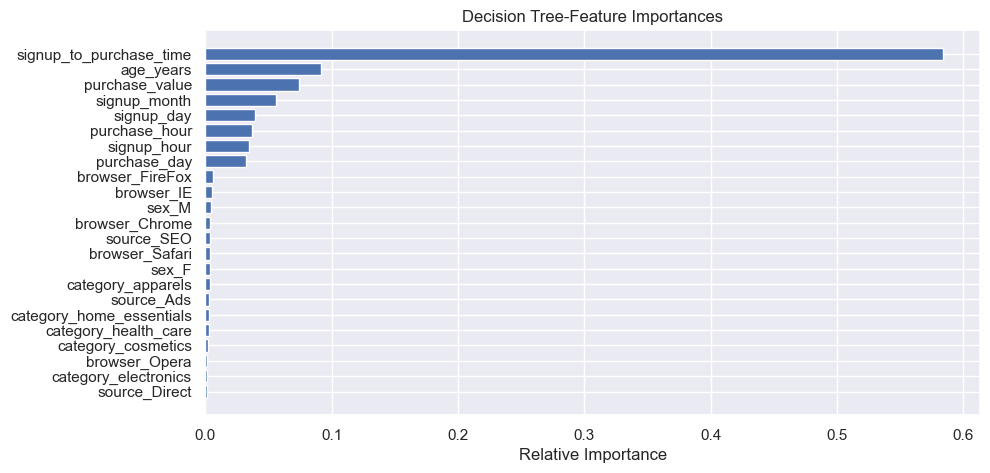

In [57]:
plt.figure(1,figsize=(10,5))
plt.title('Decision Tree-Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

*We see that most important features are the ones which were created during feature engineering*

**Predict and Evaluate**

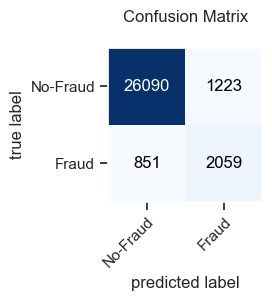

In [58]:
y_pred_dt = dtree.predict(X_test_df)     #  If predicion > 0.5, u get 1 and else 0
cm=confusion_matrix(y_test,y_pred_dt,labels=(0,1))
fig = plot_confusion_matrix(cm, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [59]:
acc_dt = accuracy_score(y_test, y_pred_dt)*100
print("Accuracy(in %):", round(acc_dt))

fscore_dt = f1_score(y_test,y_pred_dt)*100
print("F1 Score(in %):", round(fscore_dt))

Accuracy(in %): 93
F1 Score(in %): 67


In [60]:
print(classification_report(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96     27313
           1       0.63      0.71      0.67      2910

    accuracy                           0.93     30223
   macro avg       0.80      0.83      0.81     30223
weighted avg       0.94      0.93      0.93     30223



*<font color=blue>Decison Tree gives an accuracy of 93% and F1 Score of 67%*

# 4b. Parallel Ensemble - Random Forest Classifier

In [61]:
# Import
from sklearn.ensemble import RandomForestClassifier

# Instantiate
rf = RandomForestClassifier(random_state=80)

# Fit
rf.fit(X_train_df, y_train)

RandomForestClassifier(random_state=80)

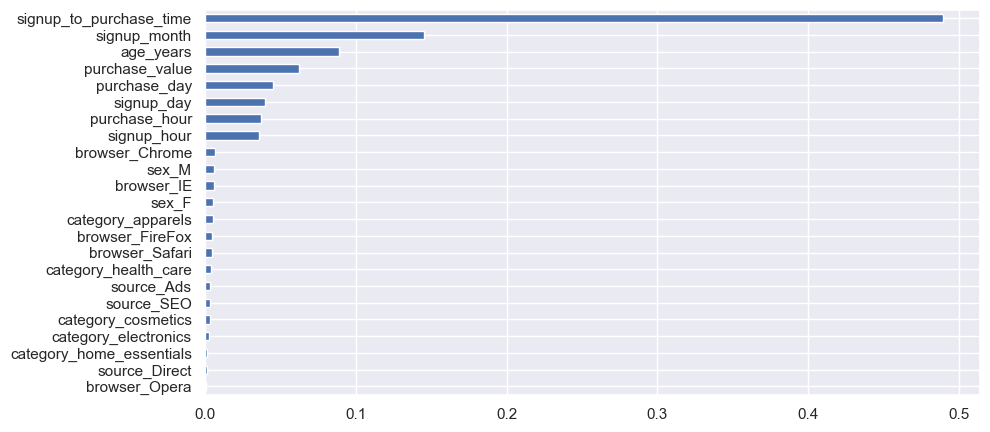

In [62]:
# Feature Importance by 1st Tree in Random Forest

pd.Series(rf.estimators_[0].feature_importances_, index=X_train_df.columns).sort_values(ascending=False)[::-1].plot.barh(figsize=(10,5));


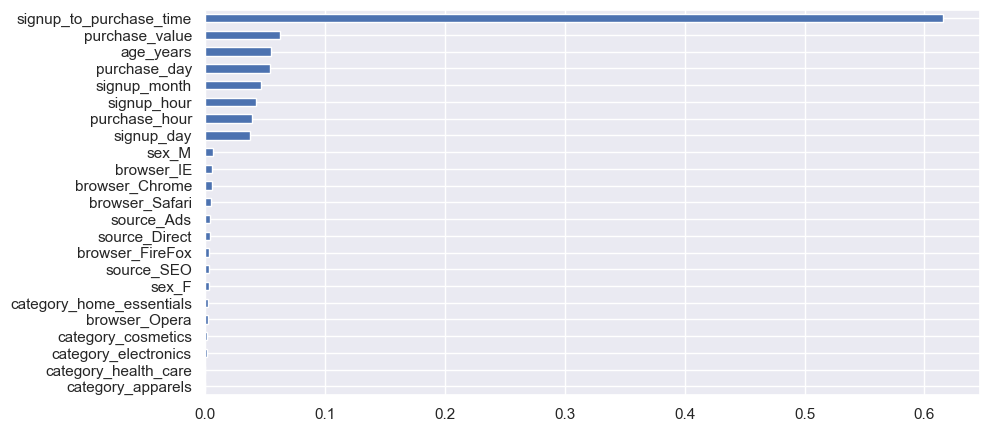

In [63]:
# Feature Importance by 5th Tree in Random Forest

pd.Series(rf.estimators_[5].feature_importances_, index=X_train_df.columns).sort_values(ascending=False)[::-1].plot.barh(figsize=(10,5));


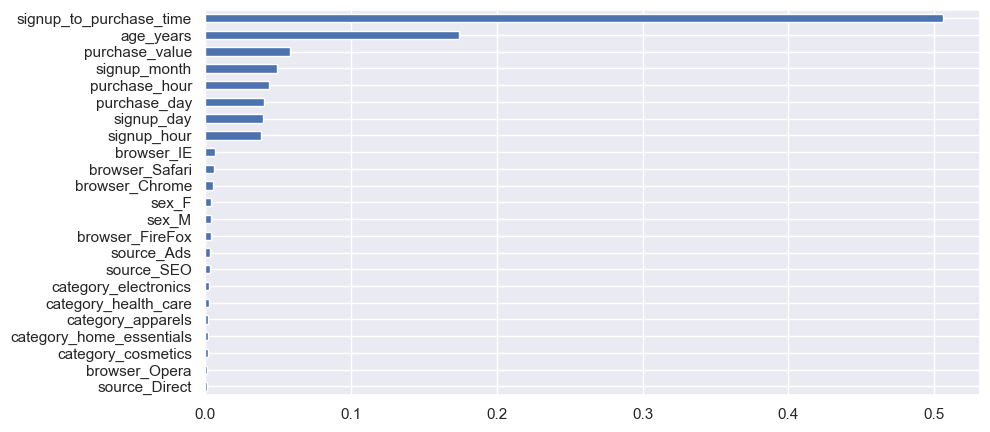

In [64]:
# Feature Importance by 40th Tree in Random Forest
 
pd.Series(rf.estimators_[9].feature_importances_, index=X_train_df.columns).sort_values(ascending=False)[::-1].plot.barh(figsize=(10,5));


*<font color=blue> Different feature importance given by each tree/estimator in Random Forest.*

In [65]:
importances = rf.feature_importances_
importances

array([0.0607794 , 0.09840016, 0.0718496 , 0.04285231, 0.07101161,
       0.04372728, 0.42906942, 0.12306272, 0.00432663, 0.00294383,
       0.0041925 , 0.00575335, 0.00450016, 0.00524427, 0.00179238,
       0.00459295, 0.00518799, 0.0052485 , 0.00280235, 0.00269525,
       0.00462156, 0.00290307, 0.00244272])

In [66]:
# Create arrays for the plot

features = X_train_df.columns
indices = np.argsort(importance)

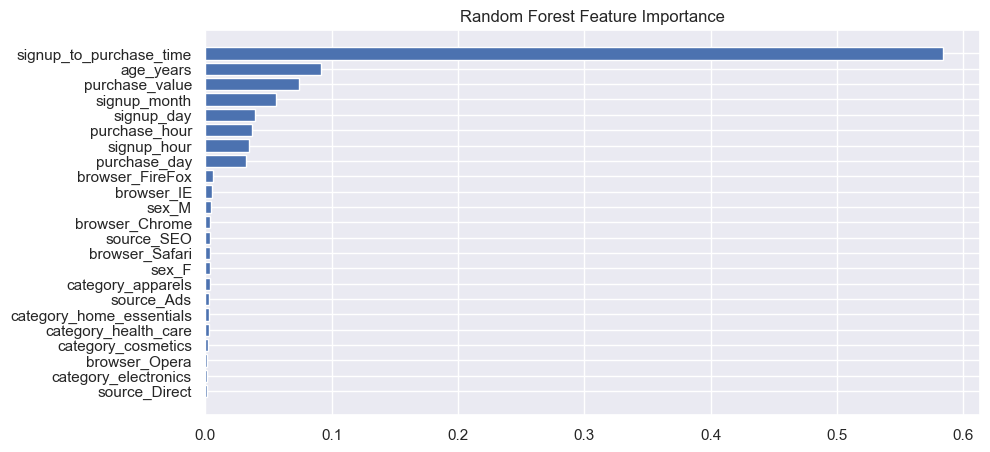

In [100]:
plt.figure(1,figsize=(10,5))
plt.title("Random Forest Feature Importance")
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

# X_train_df.shape[0] is rows and X_train_df.shape[1] is columns

#plt.yticks(range(X_train_df.shape[1]), names)
plt.show()

#feature importances averaged over all the trees in the forest. 

**Predict and Evaluate**

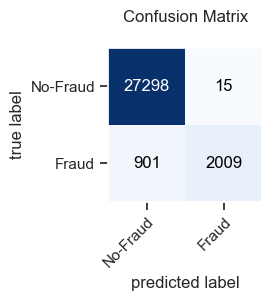

In [68]:
y_pred_rf = rf.predict(X_test_df)     #  If predicion > 0.5, u get 1 and else 0
cm=confusion_matrix(y_test,y_pred_rf,labels=(0,1))
fig = plot_confusion_matrix(cm, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [69]:
acc_rf = accuracy_score(y_test, y_pred_rf)*100
print("Accuracy(in %):", round(acc_rf))

fscore_rf = f1_score(y_test,y_pred_rf)*100
print("F1 Score(in %):", round(fscore_rf))

Accuracy(in %): 97
F1 Score(in %): 81


In [70]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27313
           1       0.99      0.69      0.81      2910

    accuracy                           0.97     30223
   macro avg       0.98      0.84      0.90     30223
weighted avg       0.97      0.97      0.97     30223



*<font color=blue>Random Forest gives an accuracy of 97% and F1 Score of 81%*

# 5. Hyperparameter Tuning

*<font color=blue>We first do RandomSearch and then based on its results go for GridSearch CV*

In [73]:
params = {'n_estimators': [300, 500, 800],
              'max_depth': [2, 5, 10],
              'min_samples_split': [2, 5, 10],
              'bootstrap': [True]}


rf_rs = RandomizedSearchCV(estimator=rf, 
                          param_distributions=params, 
                           # parameters in which we want to search optimal values
                          scoring='f1', 
                          cv=5,n_jobs=-1).fit(X_train_df, y_train)


# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', rf_rs.best_params_)
print('Best F1 score:', rf_rs.best_score_)


/Users/sylvia/opt/anaconda3/envs/tf_dl/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 10, 'bootstrap': True}
Best F1 score: 0.7974578864431126


In [75]:
params = {'n_estimators': [250, 300, 350],
              'max_depth': [8, 10, 12],
              'min_samples_split': [8, 10, 12]}
              

rf_gs = GridSearchCV(estimator=rf, 
                      param_grid=params, # parameters in which we want to search optimal values
                      scoring='f1', 
                      cv=5,n_jobs=-1).fit(X_train_df, y_train)


# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', rf_gs.best_params_)
print('Best F1 score:', rf_gs.best_score_)



/Users/sylvia/opt/anaconda3/envs/tf_dl/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'max_depth': 12, 'min_samples_split': 8, 'n_estimators': 300}
Best F1 score: 0.7975844717538797


In [77]:
# Fit on Hyperparameter Tuned Model

rf_gs.fit(X_train_df, y_train)

y_pred_rfo = rf_gs.predict(X_test_df)     



/Users/sylvia/opt/anaconda3/envs/tf_dl/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy(in %): 97
F1 Score(in %): 81


# 6. Model Evaluation



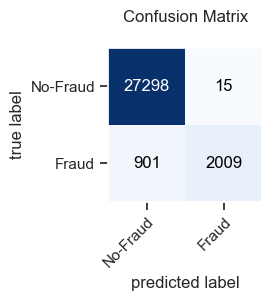

In [98]:
cm=confusion_matrix(y_test,y_pred_rfo,labels=(0,1))
fig = plot_confusion_matrix(cm, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [78]:
acc = accuracy_score(y_test, y_pred_rfo)*100
print("Accuracy(in %):", round(acc))

fscore = f1_score(y_test,y_pred_rfo)*100
print("F1 Score(in %):", round(fscore))


Accuracy(in %): 97
F1 Score(in %): 81


In [99]:
print(classification_report(y_test, y_pred_rfo))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27313
           1       0.99      0.69      0.81      2910

    accuracy                           0.97     30223
   macro avg       0.98      0.84      0.90     30223
weighted avg       0.97      0.97      0.97     30223



## ROC & AUC Evaluations

In [82]:
# Compute ROC curve and ROC area
from sklearn.metrics import roc_curve, auc

y_score = rf_gs.predict_proba(X_test_df)[:, 1]   # predicted probabilities

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

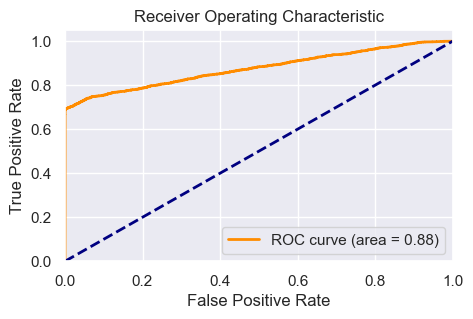

In [89]:
# Plot
plt.figure(figsize=(5,3))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()